In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bisect
import gc
from IPython.display import display
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

# Grid generation and plotting

In [2]:
def generate_grid(dots, grid_step = (1.5,1.2)):
    """Covers dots with an apropriate grid
        arguments:
            dots: array of dots [[x1,y1],[x2,y2],..,[xn,yn]]
            grid_step: tuple (x_step,y_step)
        return value: [x_ticks, y_ticks]
    """
    x,y = list(zip(*dots))
    min_x, min_y, max_x, max_y = min(x), min(y), max(x), max(y)
    x_tick_step = grid_step[0]
    y_tick_step = grid_step[1]
    x_ticks = np.arange(min_x - 5.5*x_tick_step, max_x + 5.5*x_tick_step, step=x_tick_step)
    y_ticks = np.arange(min_y - 5.5*y_tick_step, max_y + 5.5*y_tick_step, step=y_tick_step)
    return [x_ticks,y_ticks]

def plot_dots_and_grid(dots, grid, counts = None, connect_points = False, dot_color = 'red', 
                       plot_size=(15,15), dot_size = 1, out_file = None):
    """Plot dots and grid
        arguments:
            dot: array of pairs [lat, lon]
            grid: tuple of arrays [lat_ticks, lon_ticks]
            connect_points: specify if points should be connected with lines
    """
    #lat and lon corespond to y and x so we're flipping axes by switching lat and lon
    dots1 = list(zip(*dots))
    dots1.reverse()
    dots1 = list(zip(*dots1))
    
    fig, ax = plt.subplots(figsize=plot_size)
    fig.autofmt_xdate()
    ax.plot(*zip(*dots1),marker = 's', color = dot_color, linestyle='', markersize=dot_size)
    if(connect_points):
        ax.plot(*zip(*dots1))
    
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='--', color='k', linewidth=0.7)
    ax.set_xticks(grid[1]); #grid is also swaped as lat and lon
    ax.set_yticks(grid[0]);
    t = list(zip(*dots1))
    stepx = abs(dots1[0][0]-dots1[1][0])
    stepy = abs(dots1[0][1]-dots1[1][1])
    ax.set_xlim([min(t[0])-stepx, max(t[0])+stepx])
    ax.set_ylim([min(t[1])-stepy, max(t[1])+stepy])
    #plotting dot counts
    if(not (counts is None)):
        for k,v in counts.items():
            ax.annotate(v, xy=((grid[1][k[0]+1]+grid[1][k[0]])/2, #and here too
                               (grid[0][k[1]+1]+grid[0][k[1]])/2))
            
    plt.show()
    if(not (out_file is None)):
        fig.savefig(f'{out_file}.png', dpi=fig.dpi)

#   Counting data in cells

In [3]:
def get_cell_index(dot_pos, grid):
    """Given a dot coordinates and grid tiks return index of grid cell lower-left and upper-right corners 
            in lat/lon_ticks array 
        arguments:
            dot_pos: tuple of dot pos [lat, lon]
            grid: tuple of arrays [lat_ticks, lon_ticks]
    """
    x_ticks = grid[0]
    y_ticks = grid[1]
    tick_begin_x = 0;
    tick_begin_y = 0;
    tick_end_x = x_ticks[-1];
    tick_end_y = y_ticks[-1];
    for i in range(1,len(x_ticks)+1): #go trhough ticks BACKWARDS and find first the line which is BEHIND the dot |*||||<-
        if x_ticks[-i]<dot_pos[0]:
            tick_begin_x = len(x_ticks)-i
            break
    for i in range(1, len(y_ticks)+1): #same
        if y_ticks[-i]<dot_pos[1]:
            tick_begin_y = len(y_ticks)-i
            break
    for i in range(len(x_ticks)): #go trhough ticks FORWARDS and find first the line which is AFTER the dot |*||||<-
        if x_ticks[i]>dot_pos[0]:
            tick_end_x = i
            break
    for i in range(len(y_ticks)): #same
        if y_ticks[i]>dot_pos[1]:
            tick_end_y = i
            break
    return [tick_begin_x, tick_begin_y, tick_end_x, tick_end_y]

def get_cell_index_x(dot_pos, grid):
    """Given a dot coordinates and grid tiks return index of grid cell lower-left corner
            in lat/lon_ticks array 
        arguments:
            dot_pos: tuple of dot pos [lat, lon]
            grid: tuple of arrays [lat_ticks, lon_ticks]
    """
    x_ticks = grid[0]
    y_ticks = grid[1]
    tick_begin_x = 0;
    tick_begin_y = 0;
    tick_end_x = x_ticks[-1];
    tick_end_y = y_ticks[-1];
    for i in range(1,len(x_ticks)+1): #go trhough ticks BACKWARDS and find first the line which is BEHIND the dot |*||||<-
        if x_ticks[-i]<dot_pos[0]:
            tick_begin_x = len(x_ticks)-i
            break
    for i in range(1, len(y_ticks)+1): #same
        if y_ticks[-i]<dot_pos[1]:
            tick_begin_y = len(y_ticks)-i
            break
    return (tick_begin_x, tick_begin_y)

def get_cell_index_xx(dot_pos, grid):
    """Given a dot coordinates and grid tiks return index of grid cell lower-left corner
            in lat/lon_ticks array 
        arguments:
            dot_pos: tuple of dot pos [lat, lon]
            grid: tuple of arrays [lat_ticks, lon_ticks]
    """
    x_ticks = grid[0]
    y_ticks = grid[1]
    tick_begin_x = 0;
    tick_begin_y = 0;
    i = bisect.bisect_right(x_ticks, dot_pos[0])
    if i:
        tick_begin_x =i-1
    i = bisect.bisect_right(y_ticks, dot_pos[1])
    if i:
        tick_begin_y =i-1
    return (tick_begin_x, tick_begin_y)
    
def check_if_line_crosses_dot(line,dot):
    """Check if line crosses the dot
        arguments: 
            line a tuple ((x0,y0),(x1,y1))
            dot: a tuple (x,y)
        algorithm:
            Simply checks if the dot meets a line equation
    """
    p1 = line[0]
    p2 = line[1]
    if p1[1]-p2[1] == 0:
        return p1[1] == dot[1]
    return (dot[1]-p1[1])*(p1[0]-p2[0])/(p1[1]-p2[1])+p1[0]-dot[0] == 0
    
def count_cross(dots, grid, x_step = None, corner_cross_counts = False):
    """Count how many times a moving point crossed a grid 
        arguments:
            dots: array of subsequent position coordinates of a point
            grid: tuple of arrays [lat_ticks, lon_ticks]
            x_step: step between x ticks (needed for processing the corner cross)
            corner_cross_counts: True or False standing for corner cross is a single or double cell cross
                (in order this to work you will need to set x_step or ValueError exception raised)
        algorithm:
            For each pair of subsequent coordinate points we esssentially count 
            how many grid tiks are between lon and lot and sum it
            Also there is a special case when we cross a corner. 
    """
    cross_cnt = 0
    for i in range(len(dots[:-1])): #
        cell1 = get_cell_index(dots[i], grid)
        cell2 = get_cell_index(dots[i+1], grid)
        cross_cnt+=abs(cell1[0]-cell2[0])
        if(corner_cross_counts):
            if(x_step is None):
                raise ValueError("You must provide x_step to treat corner cross as a single cross ")
            ll = grid[0][cell1[0]],grid[1][cell1[1]] #get lower-left and lower-right corners of cell
            lr = grid[0][cell1[0]]+x_step,grid[1][cell1[1]]
            if(check_if_line_crosses_dot((dots[i],dots[i+1]),ll) or check_if_line_crosses_dot((dots[i],dots[i+1]),lr)):
                continue
        cross_cnt+=abs(cell1[1]-cell2[1])
    return cross_cnt

def post_proc_cell_dic(cell_dic, grid):
    """Given a cell dictionary of {'(lat_index,lon_index)':point_count} and a grid of cells
        return DataFrame ('Center_cell_lat, center_cell_lon, point_count')
    """
    result = []
    for k,v in cell_dic.items():
        result.append([(grid[0][k[0]+1]+grid[0][k[0]])/2, (grid[1][k[1]+1]+grid[1][k[1]])/2, v])
    return result
def count_points_in_cells(dots, grid):
    """Count the number of points that fall within each grid cell
        arguments:
            dots: array of subsequent position coordinates of a point 
            grid: tuple of arrays [lat_ticks, lon_ticks]
        return value:
            dictionary of pairs (cell_right_lower_corner_index_in_ticks_array, count_of_dots)
    """
    cell_dict = {}
    prog = 0
    for dot in dots:
        prog +=1
        cell = get_cell_index_xx(dot, grid);
        if cell in cell_dict:
            cell_dict[cell] += 1
        else:
            cell_dict[cell] = 1
    return cell_dict
def cell_feature_cnt(dots, grid, feature_list):
    """Summ all features from feature list for each dot among cells
    """
    cell_dict = {}
    prog = 0;
    feature_cnt = len(feature_list)
    for dot in dots:
        cell = get_cell_index_xx(dot, grid);
        if cell in cell_dict:
            cell_dict[cell][0] += 1
        else:
            cell_dict[cell] = [0]*(feature_cnt+1)
            cell_dict[cell][0] += 1
        for i in range(feature_cnt):
            cell_dict[cell][i+1] += feature_list[i][prog]
        prog += 1
    return cell_dict
def cell_avg(dots,grid,feature_list):
    """Compute avarage value of feature in feature list among cells
        arguments:
            dots,grid - as above
            feature_list - a list of list containing specific feature, e.g. [[t1,t2,t3, ...], [v1,v2,v3, ...], ...]
        return value:
            dictionary of avarages among cells {cell1: [av_t, av_v, ...], ...}. The order of avarage values 
                corresponds to the order in which they were supplied
    """
    cnt_dict = cell_feature_cnt(dots, grid, feature_list)
    res = dict.fromkeys(cnt_dict.keys())
    for key in cnt_dict:
        cnt = cnt_dict[key][0]
        res[key] = [val/cnt for val in cnt_dict[key][1:]]
    return res
def count_points_in_cells_feature(dots, grid, features):
    """Count the number of points that fall within each grid cell having a given feature
        arguments:
            dots: array of subsequent position coordinates of a point 
            grid: tuple of arrays [lat_ticks, lon_ticks]
        return value:
            dictionary of form: {cell_1: {feature_value_1: value1, feature_value_2: value2,  ...}, ...}
    """
    cell_dict = {}
    for dot, feature in zip(dots, features):
        cell = get_cell_index_xx(dot, grid);
        if not cell in cell_dict:
            cell_dict[cell] = {feature: 1}
        elif feature in cell_dict[cell]:
            cell_dict[cell][feature] += 1
        else:
            cell_dict[cell][feature] = 1
    return cell_dict

# Count and plot example

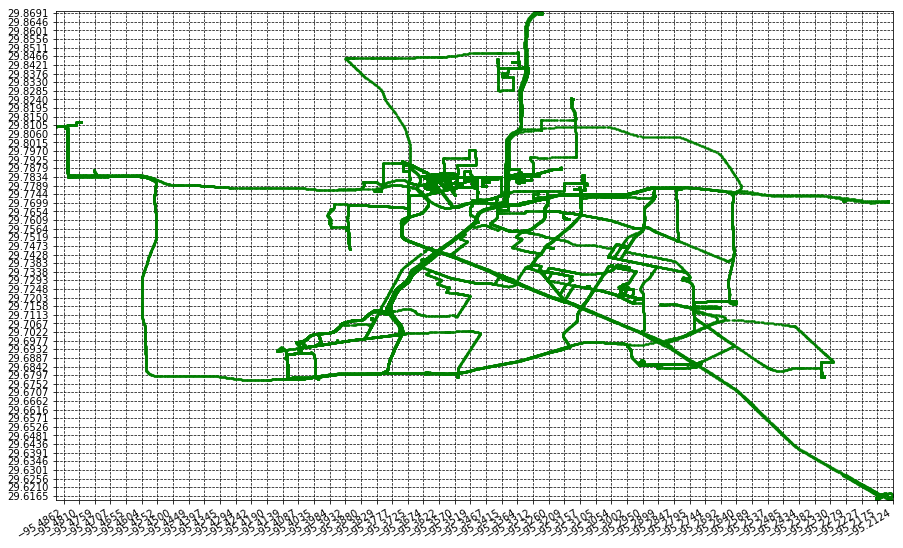

In [4]:
 #load dataset
data = pd.read_csv('mobile-1-alldata.csv').dropna()[:] #:count of dots to load from your dataset
#data = data[pd.to_numeric(data['Temp'])<29] #filter the input

#get lat lon
x = data['Lat']
y = data['Long']


#get features needed
Temp, ws, date = list(data['Temp']), list(data['WS']),list(data['Datetime'])

#get features needed
Pm25 = list(data['PM25'])

#pack in dots
dots = list(zip(x,y)) 

#clean up unused memory
x=[]
y=[]
data=[]
gc.collect()    
    
#generate grid {gridsize = m/(m in 1 deg)}
latgrid_size = 500/110847.38
longgrid_size = 500/96775.13

g = generate_grid(dots,(latgrid_size,longgrid_size))

#count points for each cell
c = count_points_in_cells(dots,g)

#get avarage Pm25 
Pm25 = cell_avg(dots, g, [Pm25])

#count how many time a point was in a cell during specific day/hour
date_hours = [d[:d.find(':')] for d in date] #trim dates to hour precision
date_days = [d[:d.find(' ')] for d in date] #trim dates to day precision
count_hrs = count_points_in_cells_feature(dots, g, date_hours)
count_days = count_points_in_cells_feature(dots, g, date_days)

#Post processing 
result = post_proc_cell_dic(c,g)
#plot result
plot_dots_and_grid(dots,g,None, plot_size=(15,10), dot_size=1, 
                   out_file='t', dot_color='green')

# Heatmap

## Functions to plot heatmap

In [6]:
def get_cell_poly(grid, lat_index, lon_index):
    """Creates a cell polygon given a grid and cell's bottom left corner indices
    """
    return [[grid[1][lon_index], [grid[0][lat_index]]],
            [grid[1][lon_index+1], grid[0][lat_index]],
            [grid[1][lon_index+1], grid[0][lat_index+1]],
            [grid[1][lon_index], grid[0][lat_index+1]],
            [grid[1][lon_index], grid[0][lat_index]]]

def get_geojson(grid):
    """Converts grid to geojson to plot on folium map. Grid cell indexes are used as feature ids 
    """
    latlen = grid[0].shape[0]
    lonlen = grid[1].shape[0]
    features_geojson = []
    for lat_i in range(latlen-1):
        for lon_i in range(lonlen-1):
            features_geojson.append({"type":'Feature',
                                     "id":str((lat_i, lon_i)),
                                     "geometry":
                                         {"type":"Polygon",
                                          "coordinates":[get_cell_poly(grid, lat_i, lon_i)]
                                         }
                                    })
    return {'type':'FeatureCollection','features':features_geojson}

def get_geojson_x(grid, c):
    """Converts grid to geojson to plot on folium map. Grid cell indexes are used as feature ids.
    ONLY CREATE A CELL IF IT HAS NON-ZERO VALUE IN c dict.
    """
    latlen = grid[0].shape[0]
    lonlen = grid[1].shape[0]
    features_geojson = []
    for lat_i in range(latlen-1):
        for lon_i in range(lonlen-1):
            if (lat_i, lon_i) in c:
                features_geojson.append({"type":'Feature',
                                         "id":str((lat_i, lon_i)),
                                         "geometry":
                                             {"type":"Polygon",
                                              "coordinates":[get_cell_poly(grid, lat_i, lon_i)]
                                             }
                                        })
    return {'type':'FeatureCollection','features':features_geojson}

def get_cell_feature_data(grid, vals):
    """Get pandas DataFrame with grid cells indexes and values rows
        Arguments:
        grid: grid
        vals: dict {cell_id:value}
    """
    latlen = grid[0].shape[0]
    lonlen = grid[1].shape[0]
    all_keys = [(lat_i, lon_i) for lat_i in range(latlen-1) for lon_i in range(lonlen-1)]
    vals = [0 if not k in vals else vals[k] for k in all_keys]
    all_keys = [str(k) for k in all_keys]
    return pd.DataFrame({'CellId':all_keys,'CellCount':vals})

def split_dict(dic):
    """Given a dict of {'key1':['val_1', 'val_2', ..., 'val_n']} return n-tuple (dic_1, dic_2, dic_n)
        where dic_i is of {'key1': val_i}
    """
    #get a sample value
    val_cnt = len(list(dic.values())[0])
    dic_tuple = [None]*val_cnt
    for i in range(val_cnt):
        dic_tuple[i] = dict.fromkeys(dic.keys())
    for i in range(val_cnt):
        for k in dic_tuple[i]:
            dic_tuple[i][k] = dic[k][i]
    return dic_tuple

## Get geojson and feature info for heatmap

In [7]:
#cell count
geojson_count = get_geojson_x(g, c) #crate geojson grid
count_data = get_cell_feature_data(g, c) #avg_temp dataframe to plot

#cell hours
count_hrs_raw = dict.fromkeys(count_hrs.keys()) #count hours a point was in a cell
for key in count_hrs_raw:
    count_hrs_raw[key] = len(count_hrs[key])
geojson_hours_count = get_geojson_x(g, count_hrs_raw)
count_hrs_raw = get_cell_feature_data(g, count_hrs_raw)

#cell hours avg
count_hrs_avg = dict.fromkeys(count_hrs.keys()) #avg hours a point was in a cell
for key in count_hrs_avg:
    count_hrs_avg[key] = sum([val for key, val in count_hrs[key].items()])/len(count_hrs[key])
geojson_hours_avg = get_geojson_x(g, count_hrs_avg)
count_hrs_avg = get_cell_feature_data(g, count_hrs_avg)
    
#cell days count
count_days_raw = dict.fromkeys(count_days.keys()) #count days a point was in a cell
for key in count_days_raw:
    count_days_raw[key] = len(count_days[key])
geojson_days_count = get_geojson_x(g, count_days_raw)
count_days_raw = get_cell_feature_data(g, count_days_raw)

#cell days avg
count_days_avg = dict.fromkeys(count_hrs.keys()) #avg days a point was in a cell
for key in count_days_avg:
    count_days_avg[key] = sum([val for key, val in count_days[key].items()])/len(count_days[key])
geojson_days_avg = get_geojson_x(g, count_days_avg)
count_days_avg = get_cell_feature_data(g, count_days_avg)

#cell pm25 avg
avgPm25 = split_dict(Pm25)[0]
geojson_pm25_avg = get_geojson_x(g, avgPm25)
avgPm25 = get_cell_feature_data(g, avgPm25)

## Make heatmap

In [35]:
#create a map
a_map = folium.Map(location=[29.69088,-95.41045], tiles = "Stamen Toner", zoom_start=10) 

#add cell count layer
a_map.choropleth(name = "Cell count", geo_data = geojson_count, fill_color='GnBu', 
                 data = count_data, columns=['CellId', 'CellCount'],
                 key_on='feature.id', line_weight=0.1, 
                 threshold_scale=list(np.array([0, 0.0001, 0.0002, 0.003, 0.01, 1])*44946), fill_opacity = 0.7)

#add hrs count layer
a_map.choropleth(name = "Hours count", fill_color='YlOrBr', 
                 geo_data=geojson_hours_count, data = count_hrs_raw, 
                 columns=['CellId', 'CellCount'],
                 key_on='feature.id', line_weight=0.1, fill_opacity = 0.7)

#add hrs avg layer
a_map.choropleth(name = "Hours avg", fill_color='YlGn', 
                 geo_data=geojson_hours_avg, data = count_hrs_avg, 
                 columns=['CellId', 'CellCount'],
                 key_on='feature.id', line_weight=0.1, fill_opacity = 0.7)

#add days count layer
a_map.choropleth(name = "Days count", fill_color='PuRd', 
                 geo_data=geojson_days_count, data = count_days_raw, 
                 columns=['CellId', 'CellCount'],
                 key_on='feature.id', line_weight=0.1, fill_opacity = 0.7)

#add days avg layer
a_map.choropleth(name = "Days avg", fill_color='YlOrRd', 
                 geo_data=geojson_days_avg, data = count_days_avg, 
                 columns=['CellId', 'CellCount'],
                 key_on='feature.id', line_weight=0.1, fill_opacity = 0.7)

#add avg Pm25
a_map.choropleth(name = "Pm25 avg", fill_color='BuPu', 
                 geo_data=geojson_pm25_avg, data = avgPm25, 
                 columns=['CellId', 'CellCount'],
                 key_on='feature.id', line_weight=0.1, fill_opacity = 0.7)

folium.LayerControl().add_to(a_map)
a_map

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# Peaks algorithm

In [36]:
# Implementation of algorithm from http://stackoverflow.com/a/22640362/6029703
import numpy as np
import pylab

def thresholding_algo(y, params):
    lag, threshold, influence = params['lag'], params['threshold'], params['influence']
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))
def detect_peaks(series):
    """Detect peaks in thresholded time series
        arguments:
            series: as thresholded time series
        return value: a list of threshold peak triples [[peak_begin, peak_end, type], ...]
            a type might be -1 or 1: down or up peak
    """
    results = []
    i = 0
    while i < len(series):
        if series[i] != 0:
            res=[i,0,series[i]] #remember peak_begin and type
            i += 1
            while i < len(series) and series[i] != 0:
                i+=1
            res[1] = i
            results.append(res)
        i += 1        
    return results
def peaks_overlay(peaks):
    """Checks if one of the two threshold peaks (see detect_peaks function description) is inside of another
        arguments:
            peaks: a tuple of threshold peaks
        return value: 0 - they overlay, -1 - first peak goes earlier, 1 - second peak goes earlier
    """
    a, b = peaks
    if ((a[0] <= b[0] and a[1] >= b[1]) or (a[0] >= b[0] and a[1] <= b[1])):
        res = 0
    else:
        if a[1] <= b[0]:
            res = -1
        else:
            res = 1
    return res
            
def peaks_compare(peaks):
    """Compares peaks
        arguments:
            peaks: a tuple of threshold peaks
        return value: -1 - first peak is wider, 1 - second is wider, 0 - peaks are same length
    """
    a,b = peaks
    if a[1] - a[0] > b[1] - b[0]:
        return -1
    elif a[1] - a[0] < b[1] - b[0]:
        return 1
    else:
        return 0
    
def get_peaks(time_series, thresholding_params):
    """Detect peaks and their types in 2 time series given thresholding params
        arguments:
            time_series: a list of time series [[val_11, val_12, ...], [val_21, val_22, ...]]
            thresholding_params: a dictionary of params for thresholding alg:
                {   
                    lag: the lag of the moving window,
                    threshold: the z-score at which the algorithm signals,
                    influence: the influence (between 0 and 1) of new signals on the mean and standard deviation
                }
        return value: a list of peaks: [peak1, peak2, ...] where 
            peaks = {type: 'A' or 'B', range: [begin, end], }
    """
    if len(time_series[0]) != len(time_series[1]):
        raise ValueError('Input series must be the same length')

    thresholded_a = thresholding_algo(time_series[0], thresholding_params)['signals']
    thresholded_b = thresholding_algo(time_series[1], thresholding_params)['signals']
    peaks_a = detect_peaks(thresholded_a)
    peaks_b = detect_peaks(thresholded_b)
    i,j=(0,0) #index of peak processed in peaks_a and peaks_b accordingly
    results = []
    while i<len(peaks_a) and j<len(peaks_b):
        res_peak = {'type':'nan', 'range': [], 'avg': None} #peak for results
        a,b = (peaks_a[i], peaks_b[j])
        r = peaks_overlay(a, b)
        #TODO: peaks might overlay but in diferent directions (one is up another is down)
        #Work it around
        if r == 0 : #peaks overlay
            res_peak['type'] = 'A'
            peaks_cmp = peaks_compare(a,b)
            if(peaks_cmp == -1):
                res_peak['range'] = a
                j += 1 #a is wider, advance b series
            elif(peaks_cmp == 1):
                res_peak['range'] = b
                i += 1 #b is wider, advance a series
            else: #peaks are equal, advance both series
                i += 1
                j += 1
        else: #peaks does not overlay
            #in that case put first in time peak and keep the second one
            if r == -1: #first peak is earlier
                i += 1 #advance a series
                res_peak['type'] = 'B'
                res_peak['range'] = a
            else:
                j += 1 #advance b series
                res_peak['type'] = 'B'
                res_peak['range'] = b
        results.append(res_peak)
    return results

def get_peaks_alt(time_series, thresholding_params):
    """Same as get peaks but implies that there are not mupltiple overlaying (/\/\ inside of /\)
    """
    if len(time_series[0]) != len(time_series[1]):
            raise ValueError('Input series must be the same length')

    thresholded_a = thresholding_algo(time_series[0], thresholding_params)['signals']
    thresholded_b = thresholding_algo(time_series[1], thresholding_params)['signals']
    peaks_a = detect_peaks(thresholded_a)
    peaks_b = detect_peaks(thresholded_b)
    i,j=(0,0) #index of peak processed in peaks_a and peaks_b accordingly
    results = []
    while i<len(peaks_a) and j<len(peaks_b):
        res_peak = {'type':'nan', 'range': [], 'avg': None} #peak for results
        a,b = (peaks_a[i], peaks_b[j])
        r = peaks_overlay([a, b])
        #TODO: peaks might overlay but in diferent directions (one is up another is down)
        #Work it around
        if r == 0 : #peaks overlay
            res_peak['type'] = 'A'
            peaks_cmp = peaks_compare([a,b])
            if(peaks_cmp == -1):
                res_peak['range'] = a
            elif(peaks_cmp == 1):
                res_peak['range'] = b
            i += 1
            j += 1
        else: #peaks do not overlay
            #in that case put first in time peak and keep the second one
            if r == -1: #first peak is earlier
                i += 1 #advance a series
                res_peak['type'] = 'B'
                res_peak['range'] = a
            else:
                j += 1 #advance b series
                res_peak['type'] = 'B'
                res_peak['range'] = b
        results.append(res_peak)
    rest_of_peaks = None
    if i < len(peaks_a): #seconds ts peaks are over
        rest_of_peaks = peaks_a[i:]
    elif j<len(peaks_b): #seconds ts peaks are over
        rest_of_peaks = peaks_b[j:]
    if not rest_of_peaks is None:
        for peak in rest_of_peaks:
            results.append({'type':'B', 'range':peak, 'avg':None})
    return results

# Usage example peaks alg

[{'type': 'A', 'range': [6, 10, 1.0], 'avg': None},
 {'type': 'B', 'range': [11, 14, 1.0], 'avg': None},
 {'type': 'B', 'range': [14, 19, 1.0], 'avg': None}]

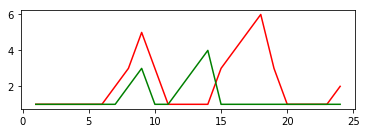

In [37]:
# Data
y = np.array([1,1,1,1,1,1,2,3,5,3,1,1,1,1,3,4,5,6,3,1,1,1,1,2])
z = np.array([1,1,1,1,1,1,1,2,3,1,1,2,3,4,1,1,1,1,1,1,1,1,1,1])

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y, color="red")
pylab.plot(np.arange(1, len(z)+1), z, color="green")

# Settings: lag = 30, threshold = 5, influence = 0
lag = 4
threshold = 6
influence = 0
thresholding_params = {'lag':lag, 'threshold':threshold, 'influence':influence}

get_peaks_alt([y,z], thresholding_params)

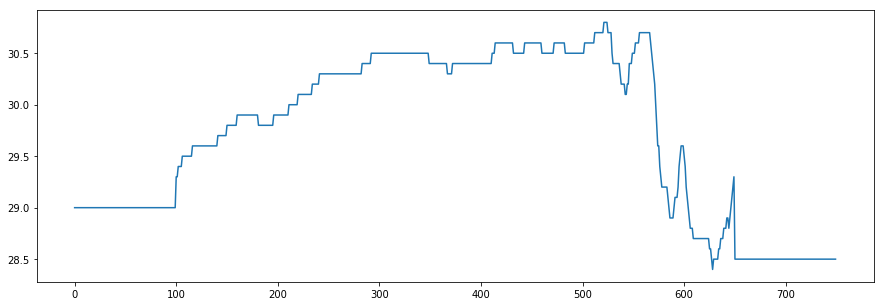

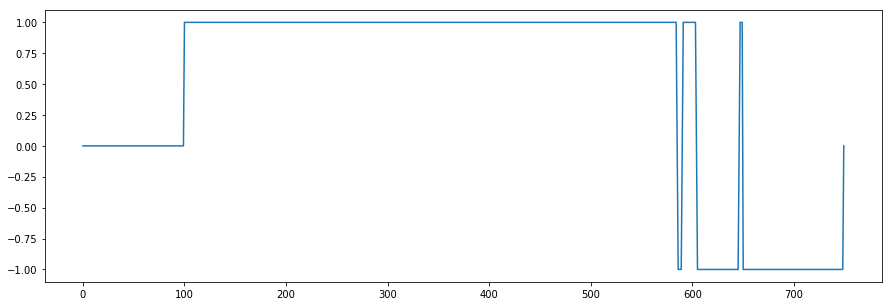

In [38]:
temp_1 = Temp[250:800]
temp_aux = [t-1 for t in temp_1]
temp_1 = [29]*100 + temp_1 +[28.5]*100
temp_aux = [27]*100 + temp_aux +[27]*100

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(temp_1)
thresholding_params = {'lag':10, 'threshold':6, 'influence':0}
res = thresholding_algo(temp_1, thresholding_params)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(res['signals'])